In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt 

import torch, torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.impute import KNNImputer
from sklearn.utils.class_weight import compute_class_weight

In [2]:
#Uncomment below to import files if using google colab

#from google.colab import files
#uploaded = files.upload()

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.13.1
11.6
True


In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [5]:
#!ls

In [6]:
df1 = pd.read_csv('train_dynamic_knn_impute_0407.csv')
df2 = pd.read_csv('train_static_0407.csv')
df3 = pd.read_csv('test_dynamic_knn_impute_0407.csv')
df4 = pd.read_csv('test_static_0407.csv')

In [7]:
df1.head(5)

,stay_id,charttime,icu_intime,charttime_hour,charttime_hour_1,charttime_hour_2,charttime_hour_6,charttime_hour_12,charttime_hour_24,calcium,...,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,bilirubin_direct,bilirubin_indirect,pt
0,30004144,2126-04-04 09:30:00,2126-04-04 13:20:25,-3.833333,-4,-2,-1,-1,-1,8.0,...,103,13.0,5.1,29,36,82,0.4,0.7,0.633333,12.5
1,30004144,2126-04-04 13:06:00,2126-04-04 13:20:25,-0.233333,-1,-1,-1,-1,-1,6.8,...,102,11.8,4.8,13,19,90,0.5,0.7,0.566667,13.7
2,30005366,2202-12-28 02:10:00,2202-12-27 17:36:59,8.550000,8,4,1,0,0,8.8,...,100,9.2,9.4,29,18,96,0.5,0.7,0.100000,32.1
3,30006983,2159-10-11 13:20:00,2159-10-12 03:56:42,-14.600000,-15,-8,-3,-2,-1,8.0,...,102,10.1,8.2,44,102,311,8.2,6.9,1.300000,19.8
4,30006983,2159-10-12 04:28:00,2159-10-12 03:56:42,0.516667,0,0,0,0,0,7.1,...,108,10.1,8.2,47,117,278,8.4,6.9,1.300000,21.5


In [8]:
df2.head(5)

,stay_id,icu_intime,vent_start,vent_end,vent_start_hour,vent_end_hour,vent_duration,vent_start_hour_1,vent_end_hour_1,vent_duration_1,...,vent_duration_2,vent_start_hour_6,vent_end_hour_6,vent_duration_6,vent_start_hour_12,vent_end_hour_12,vent_duration_12,vent_start_hour_24,vent_end_hour_24,vent_duration_24
0,30004144,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,26.650000,51.650000,25.000000,26,51,25,...,12,4,8,4,2,4,2,1,2,1
1,30005366,2202-12-27 17:36:59,2202-12-28 14:00:00,2202-12-28 20:00:00,20.383333,26.383333,6.000000,20,26,6,...,3,3,4,1,1,2,0,0,1,0
2,30006983,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,14.050000,63.050000,49.000000,14,63,49,...,24,2,10,8,1,5,4,0,2,2
3,30023204,2124-07-09 16:43:55,2124-07-11 16:00:00,2124-07-12 16:10:00,47.266667,71.433333,24.166667,47,71,24,...,12,7,11,4,3,5,2,1,2,1
4,30031418,2156-03-05 14:11:00,2156-03-07 22:06:00,2156-03-08 08:00:00,55.916667,65.816667,9.900000,55,65,10,...,5,9,10,1,4,5,0,2,2,0


In [9]:
df1['stay_id'].value_counts().nlargest(5)

37607624    196
30515259    130
33572547     93
34776632     77
36606626     62
Name: stay_id, dtype: int64

In [10]:
df1['charttime_hour_1'].describe()

count    4220.000000
mean     -244.996445
std       591.332212
min     -3598.000000
25%      -164.000000
50%       -12.000000
75%         3.000000
max        12.000000
Name: charttime_hour_1, dtype: float64

In [11]:
hour_range = [12, 6]
for i in range(9):
    hour_range.append(-i*6)
hour_range = hour_range[::-1]
hour_range

[-48, -42, -36, -30, -24, -18, -12, -6, 0, 6, 12]

In [12]:
def prepX(df, rangelist, impt_col):
    df_copy = df.copy()
    df_drop = df_copy[df_copy['charttime_hour']>=min(rangelist)]
    df_norm = df_drop.copy()
    for col in df_norm.loc[:,'calcium':'pt']:
        if df_norm[col].dtype == 'float64' or df_norm[col].dtype == 'int64':
            df_norm[col] = (df_norm[col]-df_norm[col].mean())/df_norm[col].std()

    nan_array = np.full((10,14),np.nan)
    id_dict = {}
    for index, row in df_norm.iterrows():
        if str(row['stay_id']) not in id_dict:
            id_dict[str(row['stay_id'])] = nan_array.copy()

    for id in id_dict:
        temp_df = df_norm.loc[df_norm['stay_id']==int(id)]
        for i in range(len(rangelist)-1):
            temp_df2 = temp_df.loc[temp_df['charttime_hour'].between(rangelist[i], rangelist[i+1], inclusive = 'left')]
            if not temp_df2.empty:
                temp_df2 = temp_df2.loc[:, impt_col]
                id_dict[id][i] = list(temp_df2.mean())
    #imputer = KNNImputer(n_neighbors=2, weights="distance")
    #imputed = {}
    #empty = []
    for id in id_dict:
        np.nan_to_num(id_dict[id], copy=False)
        
        #imputed[id] = imputer.fit_transform(id_dict[id])
        #if imputed[id].size == 0:
            #empty.append(id)
        
    #for id2 in empty:
        #imputed.pop(id2)
    return id_dict

In [13]:
def prepY(df, X_dict):
    new_df = pd.DataFrame(columns = [df.columns])
    for x in X_dict:
        if int(x) in df['stay_id'].values:
            if new_df.empty:
                new_df = df.loc[df['stay_id']==int(x), :]
            else:
                new_df = pd.concat([new_df, df.loc[df['stay_id']==int(x), :]])
    return new_df

In [14]:
col_to_include = ['calcium', 'creatinine', 'glucose', 
                  'sodium','chloride','hemoglobin','wbc','alt','ast','alp',
                  'bilirubin_total','bilirubin_direct','bilirubin_indirect','pt']

In [15]:
def prepTensors(X_train_dict, df2, X_test_dict, df4, label_col):
    X_train = torch.from_numpy(np.stack(list(X_train_dict.values())))
    y_train = torch.transpose(torch.Tensor([prepY(df2, X_train_dict)[label_col]]), 0, 1)
    print('Length of X and Y train:', len(X_train), len(y_train))
    
    X_test = torch.from_numpy(np.stack(list(X_test_dict.values())))
    y_test = torch.transpose(torch.Tensor([prepY(df4, X_test_dict)[label_col]]), 0, 1)
    print('Length of X and Y test:', len(X_test), len(y_test))
    
    X_train = X_train.float()
    y_train = y_train.float()
    X_test = X_test.float()
    y_test = y_test.float()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    return X_train, y_train, X_test, y_test

In [16]:
class sphDataSet(Dataset):
    def __init__(self, input_X, input_y1):
        self.x = input_X
        self.y1 = input_y1
    #    self.y2 = input_y2
        self.n_samples = len(input_y1)

    def __getitem__(self,index):
        return self.x[index], self.y1[index]
        #, self.y2[index]

    def __len__(self):
        return self.n_samples


In [17]:
def prepdataloader(x, y, batchsize):
    train_dataset = sphDataSet(x, y)
    train_dataLoader = DataLoader(train_dataset,
                            batch_size = batchsize,
                            shuffle = True,
                            num_workers=0)
    return train_dataset, train_dataLoader

# TCN Model

In [18]:
'''
TCN source from https://github.com/locuslab/TCN
'''
# removes (k-1) elements from the output on the right. Ensures causality. We first pad and then chomp.
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# a single temporal layer/block
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
    
# Create different layers with different dilation sizes
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [19]:
'''
TCN source from https://github.com/locuslab/TCN
'''

# a TCN mode with softmax for classification

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, groups, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(groups, num_channels, kernel_size, dropout=dropout)
        self.conv = weight_norm(nn.Conv1d(input_size, groups, kernel_size=1, groups=groups))
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()
#        self.sig = nn.Sigmoid()
#        self.tanh = nn.Tanh()
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.unsqueeze(x, 2)
        output = self.conv(x)
        output = self.tcn(output)
        #print(output.shape, output)

        output = self.linear(output[:,:,-1])
        #print(output.shape, output)
        return output

# Helper Functions

In [20]:
def plotloss(var, str_input, graph):
    plt.title(f'Loss against epoch ({str_input}, {var})')
    ax = plt.subplot(111)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #plt.ylim(0, 4)
    
    y = graph[f'ce__{str_input}_24h']
    num_epochs  = range(len(y))
    
    plt.plot(num_epochs, y, label=f'min={min(y)}') 

    ax.legend()

In [21]:
def plotacc(var, str_input, graph):
    plt.title(f'Accuracy against epoch ({str_input}, {var})')
    ax = plt.subplot(111)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    #plt.ylim(0, 4)
    y = graph[f'ce__{str_input}_24h']
    num_epochs  = range(len(y))
    plt.plot(num_epochs, y, label=f'max={max(y)}')

    ax.legend()

In [22]:
def get_weight(y):
    y_np = y.reshape(-1).cpu().detach().numpy()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_np), y=y_np)
    class_weights = torch.tensor(class_weights,dtype=torch.float)
    class_weights = class_weights.to(device)
    return class_weights

In [23]:
def train_evaluate_cat_weighted(model, dataloader, dataset, X_test, y_test, class_weights, epoch, name):
    criterion  = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
    global lr
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_count = 0 
    loss_init = 0 
    loss_graph = []
    all_acc = []
    for ep in range(epoch):
        model.train()
        running_loss = 0.0
        for x, y in dataloader:   
            y = y.type(torch.long).squeeze().cuda()
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if abs(loss_init- running_loss/len(dataset)) < 0.001:
            loss_count +=1
        #if loss_count > 10:
         #   break
        loss_init = running_loss/len(dataset)
        loss_graph.append(running_loss/len(dataset))

        acc = 0 
        model.eval() 
        output = model(X_test)
        output = nn.functional.softmax(output, dim = 1).detach().cpu().numpy()
        output = np.argmax(output, axis = 1)
        
        labels = y_test.detach().cpu().numpy()
        labels = np.concatenate(labels).astype(int)
        acc = (sum(labels==output)/len(output))*100
        all_acc.append(acc)
        
        if ep % 100 == 0:
            print(f'[{ep + 1}] loss: {running_loss/len(dataset):.3f}')
            print('Test Accuracy:', acc)
            
    model.eval() 
    output = model(X_test)
    output = nn.functional.softmax(output, dim = 1).detach().cpu().numpy()
    output = np.argmax(output, axis = 1)
    output_cpu = output.flatten()
    df5[f'{name}']=output_cpu.tolist()
    
    print('Finished Training')
    return loss_graph, output, all_acc

# Variables

In [24]:
df5 = prepY(df4, prepX(df3, hour_range, col_to_include))

In [25]:
X_train_dict = prepX(df1, hour_range, col_to_include)
X_test_dict = prepX(df3, hour_range, col_to_include)

In [26]:
df2['vent_start_hour_6'] = df2['vent_start_hour_6'] - 2
df4['vent_start_hour_6'] = df4['vent_start_hour_6'] - 2
df2['vent_start_hour_12'] = df2['vent_start_hour_12'] - 1
df4['vent_start_hour_12'] = df4['vent_start_hour_12'] - 1

print('Vent Start Hour unique values:')
print(len(df2['vent_start_hour_6'].unique()), df2['vent_start_hour_6'].unique())
print(len(df4['vent_start_hour_6'].unique()), df4['vent_start_hour_6'].unique())
print(len(df2['vent_start_hour_12'].unique()), df2['vent_start_hour_12'].unique())
print(len(df4['vent_start_hour_12'].unique()), df4['vent_start_hour_12'].unique())
print(len(df2['vent_start_hour_24'].unique()), df2['vent_start_hour_24'].unique())
print(len(df4['vent_start_hour_24'].unique()), df4['vent_start_hour_24'].unique())

Vent Start Hour unique values:
8 [2 1 0 5 7 3 6 4]
8 [7 2 1 4 5 6 3 0]
4 [1 0 2 3]
4 [3 1 0 2]
3 [1 0 2]
3 [2 1 0]


In [27]:
print('Vent Duration unique values:')
print(len(df2['vent_duration_6'].unique()), df2['vent_duration_6'].unique())
print(len(df2['vent_duration_12'].unique()), df2['vent_duration_12'].unique())
print(len(df2['vent_duration_24'].unique()), df2['vent_duration_24'].unique())

Vent Duration unique values:
36 [ 4  1  8  0  3 35  6  2  9 12 16 13  5 15 17 31 18 11  7 10 27 33 14 19
 21 30 26 20 28 24 34 25 23 22 32 29]
18 [ 2  0  4  1 17  3  6  8  7 15  9  5 13 16 10 14 12 11]
9 [1 0 2 8 3 4 7 6 5]


In [30]:
print(df4. loc(df4['vent_duration_24']==0,)

0      0
1      0
2      0
3      3
4      1
      ..
510    0
511    3
512    7
513    1
514    1
Name: vent_duration_24, Length: 515, dtype: int64


# Final CE model on start_hour

In [28]:
input_size = 140 #num features * num intervals
groups = 10 #10 time intervals
nhid = 9
level = 10
kernel_size = 4
dropout = 0.6
lr = 0.01

size = 64
output_sizes = {'vent_start_hour_6':8, 'vent_start_hour_12':4, 'vent_start_hour_24':3,
               'vent_duration_6':36, 'vent_duration_12':18, 'vent_duration_24':9}
epoch = 1001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_graphs_final = {}
all_acc_final = {}

print(f'CE model on vent_start_hour_24')
label_col =  'vent_start_hour_24'
output_size = output_sizes[label_col]
X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
model = model.to(device)
weight = get_weight(y_train)
loss_graph, output, all_acc = train_evaluate_cat_weighted(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, weight, epoch, f'ce__start_hour_24h')
loss_graphs_final[f'ce__start_hour_24h'] = loss_graph
all_acc_final[f'ce__start_hour_24h'] = all_acc
        
print('=========================')
print()

CE model on vent_start_hour_24
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 0.017
Test Accuracy: 10.1364522417154
[101] loss: 0.014
Test Accuracy: 28.26510721247563
[201] loss: 0.014
Test Accuracy: 30.60428849902534
[301] loss: 0.014
Test Accuracy: 37.03703703703704
[401] loss: 0.014
Test Accuracy: 31.57894736842105
[501] loss: 0.014
Test Accuracy: 28.654970760233915
[601] loss: 0.014
Test Accuracy: 30.01949317738791
[701] loss: 0.014
Test Accuracy: 30.409356725146196
[801] loss: 0.014
Test Accuracy: 28.460038986354775
[901] loss: 0.014
Test Accuracy: 30.60428849902534
[1001] loss: 0.014
Test Accuracy: 30.60428849902534
Finished Training



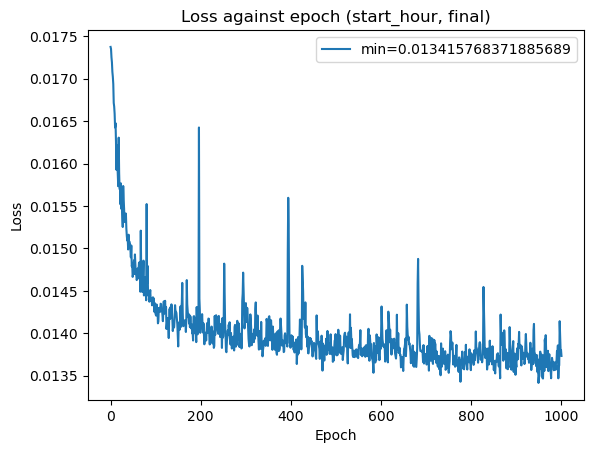

In [29]:
plotloss('final', 'start_hour', loss_graphs_final)

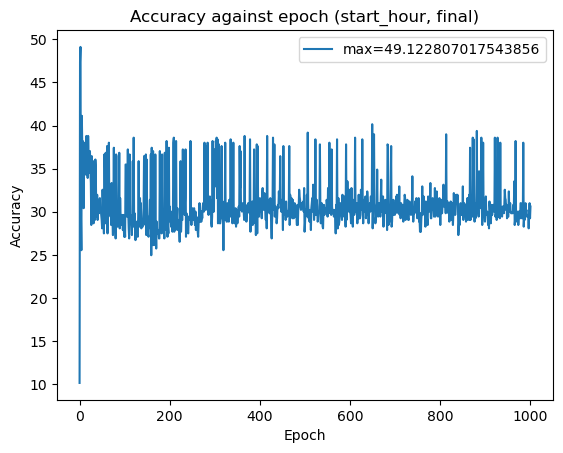

In [30]:
plotacc('final', 'start_hour', all_acc_final)

In [31]:
input_size = 140 #num features * num intervals
groups = 10 #10 time intervals
nhid = 10
level = 10
kernel_size = 4
dropout = 0.4
lr = 0.02

size = 64
output_sizes = {'vent_start_hour_6':8, 'vent_start_hour_12':4, 'vent_start_hour_24':3,
               'vent_duration_6':36, 'vent_duration_12':18, 'vent_duration_24':9}
epoch = 1001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'CE model on vent_duration_24')
label_col =  'vent_duration_24'
output_size = output_sizes[label_col]
X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
model = model.to(device)
weight = get_weight(y_train)
loss_graph, output, all_acc = train_evaluate_cat_weighted(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, weight, epoch, f'ce__duration_24h')
loss_graphs_final[f'ce__duration_24h'] = loss_graph
all_acc_final[f'ce__duration_24h'] = all_acc
        
print('=========================')
print()

CE model on vent_duration_24
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 0.035
Test Accuracy: 22.027290448343077
[101] loss: 0.028
Test Accuracy: 8.187134502923977
[201] loss: 0.028
Test Accuracy: 6.237816764132553
[301] loss: 0.027
Test Accuracy: 5.458089668615984
[401] loss: 0.027
Test Accuracy: 9.551656920077972
[501] loss: 0.027
Test Accuracy: 11.500974658869396
[601] loss: 0.027
Test Accuracy: 5.0682261208577
[701] loss: 0.027
Test Accuracy: 10.721247563352826
[801] loss: 0.027
Test Accuracy: 10.916179337231968
[901] loss: 0.027
Test Accuracy: 9.161793372319687
[1001] loss: 0.027
Test Accuracy: 11.695906432748536
Finished Training



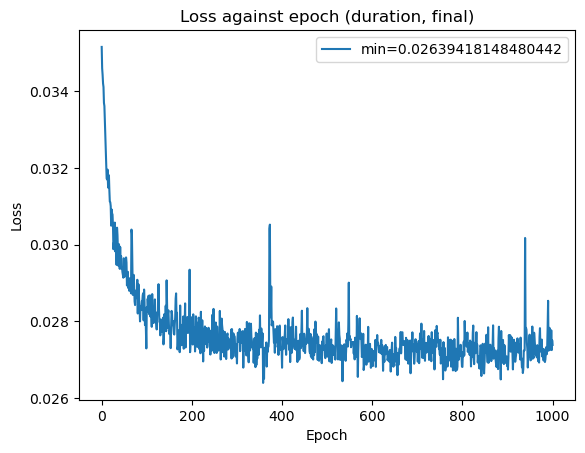

In [32]:
plotloss('final', 'duration', loss_graphs_final)

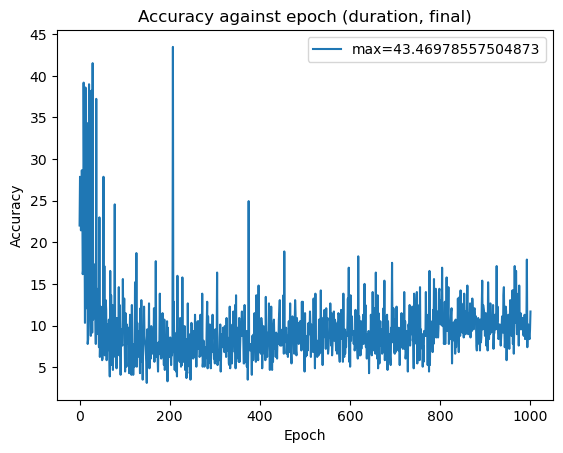

In [33]:
plotacc('final', 'duration', all_acc_final)